In [184]:
# last modified May 2023
# created by G Oldford
# purpose: plots reporting model perf using LH and SST 
#
# data in: csv's of stats from python analysis app run on server
#          manually input mean and std found in figs produced by Pyap
# data out: 

# notes: 
#  - tried cdat (won't install easily on windows)
#  - tried custom code snippet from ycopin (see below)
#  - tried xcdat (not sure there is a taylor diag)
#  - tried SkillMetrics (won't install via pip or conda, but cloned repo locally)
#  - May 28 - SSS is poor.To do: Two plot options - choose one. Add target plot. Add SST buoy data

In [1]:
!python --version

Python 3.11.3


In [78]:
import scipy.io
import os
import pickle
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats
import sys
from matplotlib import rcParams
from matplotlib.markers import MarkerStyle
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.colors as clr
from matplotlib.ticker import ScalarFormatter
import math
from math import log10, floor
from array import array
import numbers
from matplotlib.lines import Line2D
import warnings
from matplotlib.markers import MarkerStyle

## read data

In [50]:
# code to check length (num of records)

# data output as pickle files by pyap
# path1 = 'D:/temp_nemo/RUN203_PLOTS_SCORES/'
path1 = 'D:/temp_nemo/RUN203_PLOTS_SCORES/'

# pic_data = "CTDcast_metrics_hindcast.pickle"
#pic_data = "CTDcast_metrics_hindcast.pickle"
pic_data = "SST_class4_SalishSea1500-RUN203.pickle"
scores = pickle.load(open(os.path.join(path1,pic_data), 'rb'))
# modelrun = 'SalishSea1500-RUN203'
modelrun = 'SalishSea1500-RUN203'

#(scores['SalishSea1500-RUN203']['scores']['Nanoose_2000-76_CastCTD_2000-09-19_0806h'].keys())
# print((scores[modelrun].keys()))
# print((scores[modelrun]['C46134_2001-02_2016-12.nc']['lat']))
# print((scores[modelrun]['C46134_2001-02_2016-12.nc']['lon']))

In [68]:
# use only buoys w/ 10+ yrs of data
buoy_list = ['46131', '46134', '46146']

In [66]:
def get_lh_stats(LH_scores, modelrun, augment_rmse, var):
    
    lh_stats_taylor = []
    lh_stats_target = []

    for lh in LH_scores[modelrun].keys():
        
        pears = LH_scores[modelrun][lh]['filt_interp_data']['scores'][var]['pearson']
        mod_stdev = LH_scores[modelrun][lh]['filt_interp_data']['scores'][var]['stdev_mod']
        obs_stdev = LH_scores[modelrun][lh]['filt_interp_data']['scores'][var]['stdev_obs']

        mod_norm_stdev = mod_stdev / obs_stdev

        crmse = LH_scores[modelrun][lh]['filt_interp_data']['scores'][var]['crmse']

        ncrmse = crmse / obs_stdev   

        # stats needed for taylor
        lh_stats_taylor.append([lh,
                                obs_stdev,
                                mod_stdev,
                                mod_norm_stdev,
                                crmse,
                                ncrmse,
                                pears])

        # stats needed for target
        rmse = LH_scores[modelrun][lh]['filt_interp_data']['scores'][var]['rmse']
        bias = LH_scores[modelrun][lh]['filt_interp_data']['scores'][var]['bias']
        nrmse = rmse / obs_stdev

        if augment_rmse == True:
            if (mod_stdev - obs_stdev) < 0:
                rmse = rmse * -1
                nrmse = nrmse * -1
                crmse = crmse * -1
                ncrmse = ncrmse * -1

        lh_stats_target.append([lh,
                                rmse,
                                crmse,
                                nrmse,
                                ncrmse,
                                bias
                               ])

    lh_stats_taylor_np = np.array(lh_stats_taylor)
    lh_stats_target_np = np.array(lh_stats_target)
    
    
    return(lh_stats_taylor_np, lh_stats_target_np)


def get_SSTbuoy_stats (SSTbuoy_scores, modelrun, augment_rmse, buoy_list):
    buoy_stats_taylor = []
    buoy_stats_target = []

    for buoy in SSTbuoy_scores[modelrun].keys():

        if buoy == "C46134_2001-02_2016-12.nc":
            buoy_bettername = '46134'
        elif buoy == "C46131_1992-10_2021-01.nc":
            buoy_bettername = '46131'
        elif buoy == "C46146_1992-03_2022-06.nc":
            buoy_bettername = '46146'
        elif buoy == "C46182_1989-09_1991-11.nc":
            buoy_bettername = '46182'
        else:
            buoy_bettername = buoy
        
        if (buoy_bettername not in buoy_list):
            continue
        
        obs_stdev = SSTbuoy_scores[modelrun][buoy]['filt_interp_data']['scores']['stdev_obs']
        mod_stdev = SSTbuoy_scores[modelrun][buoy]['filt_interp_data']['scores']['stdev_mod']
        mod_norm_stdev = mod_stdev / obs_stdev
        crmse = SSTbuoy_scores[modelrun][buoy]['filt_interp_data']['scores']['crmse']
        ncrmse = crmse / obs_stdev
        pears = SSTbuoy_scores[modelrun][buoy]['filt_interp_data']['scores']['pearson']
        
        # for taylors
        buoy_stats_taylor.append([buoy_bettername,
                                  obs_stdev,
                                  mod_stdev,
                                  mod_norm_stdev,
                                  crmse,
                                  ncrmse,
                                  pears]) 
        # for target
        rmse = SSTbuoy_scores[modelrun][buoy]['filt_interp_data']['scores']['rmse']
        bias = SSTbuoy_scores[modelrun][buoy]['filt_interp_data']['scores']['bias']
        nrmse = rmse / obs_stdev

        if augment_rmse == True:
            if (mod_stdev - obs_stdev) < 0:
                rmse = rmse * -1
                crmse = crmse * -1
                nrmse = nrmse * -1
                ncrmse = ncrmse * -1

        buoy_stats_target.append([buoy_bettername,
                                  rmse,
                                  crmse,
                                  nrmse,
                                  ncrmse,
                                  bias])

    # np is easier
    buoy_stats_taylor_np = np.array(buoy_stats_taylor)
    buoy_stats_target_np = np.array(buoy_stats_target)
    
    return(buoy_stats_taylor_np, buoy_stats_target_np)

In [69]:
######### EXTRACT SalishSea1500-RUN203 #######

# data output as pickle files by pyap
path1 = 'D:/temp_nemo/RUN203_PLOTS_SCORES/'
LH_pic_data = "LH_class4_RUN203_hindcast.pickle"
LH_scores = pickle.load(open(os.path.join(path1,LH_pic_data), 'rb'))
modelrun = 'SalishSea1500-RUN203'

# 'augment' rmse for target as per Kärnä et al 2021
# ie rmse < 0 if sig_mod - sig_obs < 0
augment_rmse = True

#LH_scores['SalishSea1500-RUN203']['cape_mudge_LH.nc']['filt_interp_data']['scores']['temperature'].keys()
# dict_keys(['skill1981', 'mean_obs', 'mean_mod', 'bias', 'crmse', 'gamma2', 'rmse', 'mae', 'mad', 'pearson', 'stdev_obs', 'stdev_mod'])

var = "temperature"
lh_stats_taylor_T_np, lh_stats_target_T_np = get_lh_stats(LH_scores, modelrun, augment_rmse, var)
var = "salinity"
lh_stats_taylor_S_np, lh_stats_target_S_np = get_lh_stats(LH_scores, modelrun, augment_rmse, var)

# SST buoy data
SSTbuoy_pic_data = "SST_class4_" + modelrun + ".pickle"
SSTbuoy_scores = pickle.load(open(os.path.join(path1,SSTbuoy_pic_data), 'rb'))

# looks like:
# SSTbuoy_scores['SalishSea1500-RUN203']['ptaw1']['filt_interp_data']['scores'].keys()
# dict_keys(['skill1981', 'mean_obs', 'mean_mod', 'bias', 'crmse', 'gamma2', 'rmse', 'mae', 'mad', 'pearson', 'stdev_obs', 'stdev_mod'])

buoy_stats_taylor_np, buoy_stats_target_np = get_SSTbuoy_stats(SSTbuoy_scores, modelrun, augment_rmse, buoy_list)

SST_taylor_np_buoys_and_LH = np.concatenate((lh_stats_taylor_T_np,buoy_stats_taylor_np))
SST_target_np_buoys_and_LH = np.concatenate((lh_stats_target_T_np,buoy_stats_target_np))


In [75]:
SST_taylor_np_buoys_and_LH

array([['active_pass_LH.nc', '3.644754', '3.8184956491820574',
        '1.0476689838121434', '1.528552119544601', '0.419384174532246',
        '0.9173148671313412'],
       ['cape_mudge_LH.nc', '3.0163114', '3.1903619356451887',
        '1.0577031032495134', '1.4401448471814995', '0.4774523093990656',
        '0.894732657296676'],
       ['chrome_island_LH.nc', '3.9074454', '3.496276512229419',
        '0.8947729595172657', '1.1499331508544315',
        '0.29429282410530283', '0.9577377732589976'],
       ['entrance_island_LH.nc', '4.1974125', '4.253294937901915',
        '1.0133135466621586', '1.1591598785816495',
        '0.27616058252792053', '0.9622935418597078'],
       ['race_rocks_LH.nc', '1.53198', '1.6350781433024357',
        '1.0672972904847615', '0.6333384432637509',
        '0.41341168140745416', '0.9222163645562538'],
       ['sheringham_point_LH.nc', '1.384478', '1.809072149445825',
        '1.3066817852986685', '0.9279741022528901', '0.6702700370541785',
        '0.8648

In [ ]:
# not done
######### EXTRACT SS500 #######
# not done given that I would need to switch to eval for the shorter runs (limited to years 2016 - 2018)

# data output as pickle files by pyap
path2 = 'D:/temp_nemo/'
LH_pic_data_ss500 = ""
LH_scores_ss500 = pickle.load(open(os.path.join(path1,LH_pic_data), 'rb'))
modelrun = ''

In [70]:
for lh in LH_scores[modelrun].keys():
    print(lh)
    print(LH_scores[modelrun][lh]['start'])
    print(LH_scores[modelrun][lh]['end'])

active_pass_LH.nc
1980-01-01 07:00:16
2011-12-31 10:01:36
cape_mudge_LH.nc
1980-01-01 14:58:08
1985-12-31 08:02:08
chrome_island_LH.nc
1980-01-01 07:00:16
2018-12-31 12:58:40
entrance_island_LH.nc
1980-01-01 07:00:16
2018-12-31 12:58:40
race_rocks_LH.nc
1980-01-01 10:59:12
2018-12-31 08:00:00
sheringham_point_LH.nc
1980-01-01 10:59:12
1988-01-05 09:59:28
sisters_islets_LH.nc
1980-01-01 07:00:16
2008-07-31 16:00:00


In [71]:
for stn in SSTbuoy_scores[modelrun].keys():
    print(stn)
    print(SSTbuoy_scores[modelrun][stn]['start'])
    print(SSTbuoy_scores[modelrun][stn]['end'])

neaw1
2016-01-01 00:00:00
2019-01-01 00:00:00
ptaw1
2016-01-01 00:00:00
2019-01-01 00:00:00
ptww1
2016-01-01 00:00:00
2019-01-01 00:00:00
tcnw1
2016-01-01 00:00:00
2019-01-01 00:00:00
46087
2015-12-31 23:51:28
2018-12-31 23:51:28
46088
2015-12-31 23:51:28
2018-12-31 23:51:28
C46131_1992-10_2021-01.nc
1992-10-20 12:07:28
2018-12-31 23:30:08
C46134_2001-02_2016-12.nc
2001-02-19 23:38:40
2016-12-09 15:40:48
C46146_1992-03_2022-06.nc
1992-03-13 18:42:08
2018-12-31 23:25:52
C46182_1989-09_1991-11.nc
1989-09-08 06:34:40
1991-11-21 21:43:28


### Taylor diag code - source 1

In [98]:
# found online - https://gist.github.com/lee1043/6c66672fa3867ee0de7ce180e8093f0a
# alt might be xcdat but no time so far to learn how

#!/usr/bin/env python
# Copyright: This document has been placed in the public domain.

"""
Taylor diagram (Taylor, 2001) implementation.
Note: If you have found these software useful for your research, I would
appreciate an acknowledgment.
"""

__version__ = "Time-stamp: <2018-12-06 11:43:41 ycopin>"
__author__ = "Yannick Copin <yannick.copin@laposte.net>"

class TaylorDiagram(object):
    """
    Taylor diagram.
    Plot model standard deviation and correlation to reference (data)
    sample in a single-quadrant polar plot, with r=stddev and
    theta=arccos(correlation).
    """

    def __init__(self, refstd,
                 fig=None, rect=111, label='_', srange=(0, 1.5), extend=False):
        """
        Set up Taylor diagram axes, i.e. single quadrant polar
        plot, using `mpl_toolkits.axisartist.floating_axes`.
        Parameters:
        * refstd: reference standard deviation to be compared to
        * fig: input Figure or None
        * rect: subplot definition
        * label: reference label
        * srange: stddev axis extension, in units of *refstd*
        * extend: extend diagram to negative correlations
        """

        from matplotlib.projections import PolarAxes
        import mpl_toolkits.axisartist.floating_axes as FA
        import mpl_toolkits.axisartist.grid_finder as GF

        self.refstd = refstd            # Reference standard deviation

        tr = PolarAxes.PolarTransform()

        # Correlation labels
        rlocs = np.array([0, 0.2, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1])
        if extend:
            # Diagram extended to negative correlations
            self.tmax = np.pi
            rlocs = np.concatenate((-rlocs[:0:-1], rlocs))
        else:
            # Diagram limited to positive correlations
            self.tmax = np.pi/2
        tlocs = np.arccos(rlocs)        # Conversion to polar angles
        gl1 = GF.FixedLocator(tlocs)    # Positions
        tf1 = GF.DictFormatter(dict(zip(tlocs, map(str, rlocs))))

        # Standard deviation axis extent (in units of reference stddev)
        self.smin = srange[0] * self.refstd
        self.smax = srange[1] * self.refstd

        ghelper = FA.GridHelperCurveLinear(
            tr,
            extremes=(0, self.tmax, self.smin, self.smax),
            grid_locator1=gl1, tick_formatter1=tf1)

        if fig is None:
            fig = plt.figure()

        ax = FA.FloatingSubplot(fig, rect, grid_helper=ghelper)
        fig.add_subplot(ax)

        # Adjust axes
        ax.axis["top"].set_axis_direction("bottom")   # "Angle axis"
        ax.axis["top"].toggle(ticklabels=True, label=True)
        ax.axis["top"].major_ticklabels.set_axis_direction("top")
        ax.axis["top"].label.set_axis_direction("top")
        ax.axis["top"].label.set_text("Correlation")

        ax.axis["left"].set_axis_direction("bottom")  # "X axis"
        ax.axis["left"].label.set_text("Standard deviation")

        ax.axis["right"].set_axis_direction("top")    # "Y-axis"
        ax.axis["right"].toggle(ticklabels=True)
        ax.axis["right"].major_ticklabels.set_axis_direction(
            "bottom" if extend else "left")

        if self.smin:
            ax.axis["bottom"].toggle(ticklabels=False, label=False)
        else:
            ax.axis["bottom"].set_visible(False)          # Unused

        self._ax = ax                   # Graphical axes
        self.ax = ax.get_aux_axes(tr)   # Polar coordinates

        # Add reference point and stddev contour
        l, = self.ax.plot([0], self.refstd, 'k*',
                          ls='', ms=10, label=label)
        
        t = np.linspace(0, self.tmax)
        r = np.zeros_like(t) + self.refstd
        self.ax.plot(t, r, 'k--', label='_')

        # Collect sample points for latter use (e.g. legend)
        self.samplePoints = [l]

    def add_sample(self, stddev, corrcoef, *args, **kwargs):
        """
        Add sample (*stddev*, *corrcoeff*) to the Taylor
        diagram. *args* and *kwargs* are directly propagated to the
        `Figure.plot` command.
        """

        l, = self.ax.plot(np.arccos(corrcoef), stddev,
                          *args, **kwargs)  # (theta, radius)
        self.samplePoints.append(l)

        return l

    def add_grid(self, *args, **kwargs):
        """Add a grid."""

        self._ax.grid(*args, **kwargs)

    def add_contours(self, levels=5, **kwargs):
        """
        Add constant centered RMS difference contours, defined by *levels*.
        """

        rs, ts = np.meshgrid(np.linspace(self.smin, self.smax),
                             np.linspace(0, self.tmax))
        # Compute centered RMS difference
        rms = np.sqrt(self.refstd**2 + rs**2 - 2*self.refstd*rs*np.cos(ts))

        contours = self.ax.contour(ts, rs, rms, levels, **kwargs)

        return contours


def test1():
    """Display a Taylor diagram in a separate axis."""

    # Reference dataset
    x = np.linspace(0, 4*np.pi, 100)
    data = np.sin(x)
    refstd = data.std(ddof=1)           # Reference standard deviation

    # Generate models
    m1 = data + 0.2*np.random.randn(len(x))     # Model 1
    m2 = 0.8*data + .1*np.random.randn(len(x))  # Model 2
    m3 = np.sin(x-np.pi/10)                     # Model 3

    # Compute stddev and correlation coefficient of models
    samples = np.array([ [m.std(ddof=1), np.corrcoef(data, m)[0, 1]]
                         for m in (m1, m2, m3)])
    print(samples)
    fig = plt.figure(figsize=(10, 4))

    ax1 = fig.add_subplot(1, 2, 1, xlabel='X', ylabel='Y')
    # Taylor diagram
    dia = TaylorDiagram(refstd, fig=fig, rect=122, label="Reference",
                        srange=(0, 1.5))

    colors = plt.matplotlib.cm.jet(np.linspace(0, 1, len(samples)))

    ax1.plot(x, data, 'ko', label='Data')
    for i, m in enumerate([m1, m2, m3]):
        ax1.plot(x, m, c=colors[i], label='Model %d' % (i+1))
    ax1.legend(numpoints=1, prop=dict(size='small'), loc='best')

    # Add the models to Taylor diagram
    for i, (stddev, corrcoef) in enumerate(samples):
        dia.add_sample(stddev, corrcoef,
                       marker='$%d$' % (i+1), ms=10, ls='',
                       mfc=colors[i], mec=colors[i],
                       label="Model %d" % (i+1))

    # Add grid
    dia.add_grid()

    # Add RMS contours, and label them
    contours = dia.add_contours(colors='0.5')
    plt.clabel(contours, inline=1, fontsize=10, fmt='%.2f')

    # Add a figure legend
    fig.legend(dia.samplePoints,
               [ p.get_label() for p in dia.samplePoints ],
               numpoints=1, prop=dict(size='small'), loc='upper right')

    return dia


def test2():
    """
    Climatology-oriented example (after iteration w/ Michael A. Rawlins).
    """

    # Reference std
    stdref = 48.491

    # Samples std,rho,name
    samples = [[25.939, 0.385, "Model A"],
               [29.593, 0.509, "Model B"],
               [33.125, 0.585, "Model C"],
               [29.593, 0.509, "Model D"],
               [71.215, 0.473, "Model E"],
               [27.062, 0.360, "Model F"],
               [38.449, 0.342, "Model G"],
               [35.807, 0.609, "Model H"],
               [17.831, 0.360, "Model I"]]

    fig = plt.figure()

    dia = TaylorDiagram(stdref, fig=fig, label='Reference', extend=True)
    dia.samplePoints[0].set_color('r')  # Mark reference point as a red star

    # Add models to Taylor diagram
    for i, (stddev, corrcoef, name) in enumerate(samples):
        dia.add_sample(stddev, corrcoef,
                       marker='$%d$' % (i+1), ms=10, ls='',
                       mfc='k', mec='k',
                       label=name)

    # Add RMS contours, and label them
    contours = dia.add_contours(levels=5, colors='0.5')  # 5 levels in grey
    plt.clabel(contours, inline=1, fontsize=10, fmt='%.0f')

    dia.add_grid()                                  # Add grid
    dia._ax.axis[:].major_ticks.set_tick_out(True)  # Put ticks outward

    # Add a figure legend and title
    fig.legend(dia.samplePoints,
               [ p.get_label() for p in dia.samplePoints ],
               numpoints=1, prop=dict(size='small'), loc='upper right')
    fig.suptitle("Taylor diagram", size='x-large')  # Figure title

    return dia




#### test of the above snipped

test
[[0.73508198 0.96707433]
 [0.5829882  0.98366632]
 [0.70778169 0.95014964]]


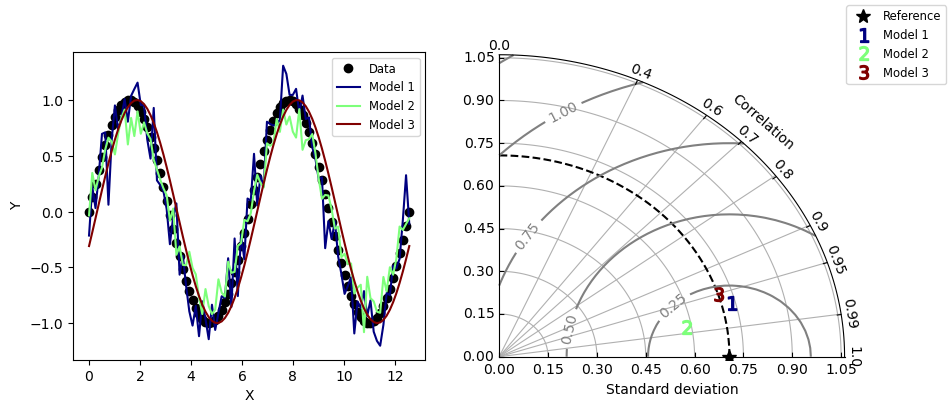

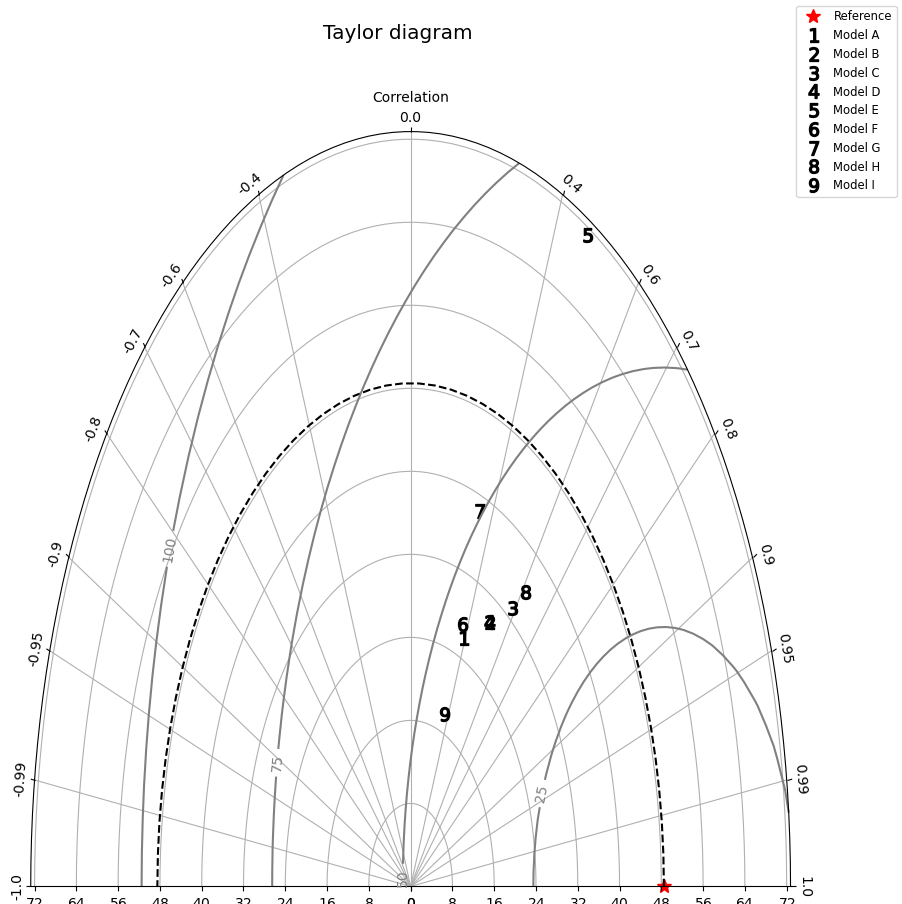

In [97]:
if __name__ == '__main__':
    print("test")
    dia = test1()
    dia = test2()

    plt.show()

### using code snippet (above) for Taylor fig

In [682]:
### lh_stats_taylor_T.append([lh,
#                               obs_stdev_T,
#                               mod_stdev_T,
#                               mod_norm_stdev_T,
#                               crmse_T,
#                               ncrmse_T,
#                               pears_T]
# SST_taylor_np_buoys_and_LH[:,]

<a list of 6 text.Text objects>

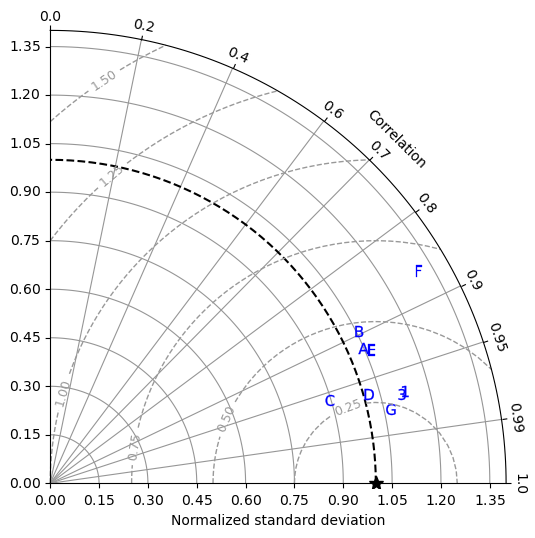

In [101]:
fig = plt.figure(figsize=(6,6))

ccoef = SST_taylor_np_buoys_and_LH[:,6].astype('f')
sdev = SST_taylor_np_buoys_and_LH[:,3].astype('f')

contour_levs = 6

#to-do this is repeated below in target
msize = 8

o_markers = {'Active Pass': {#'symbol':'1',
                             'symbol':r'$\mathdefault{A}$',
                             'size': msize,
                             'facecolor': facecolor1,
                             'edgecolor': edgecolor1,
                             'edgewidth': medgew1,
                            'labelcolor': 'b'},
             'Cape Mudge': {#'symbol':'2',
                             'symbol':r'$\mathdefault{B}$',
                             'size': msize,
                             'facecolor': facecolor1,
                             'edgecolor': edgecolor1,
                             'edgewidth': medgew1,
                            'labelcolor': 'b'},
             'Chrome Is.': {#'symbol':'3',
                             'symbol':r'$\mathdefault{C}$',
                             'size': msize,
                             'facecolor': facecolor1,
                             'edgecolor': edgecolor1,
                             'edgewidth': medgew1,
                            'labelcolor': 'b'},
             'Entrance Is.': {#'symbol':'4',
                             'symbol':r'$\mathdefault{D}$',
                             'size': msize,
                             'facecolor': facecolor1,
                             'edgecolor': edgecolor1,
                             'edgewidth': medgew1,
                            'labelcolor': 'b'},
             'Race Rocks': {#'symbol':'+',
                             'symbol':r'$\mathdefault{E}$',
                             'size': msize,
                             'facecolor': facecolor1,
                             'edgecolor': edgecolor1,
                             'edgewidth': medgew1,
                            'labelcolor': 'b'},
             'Sheringham Pt.': {#'symbol':'x',
                             'symbol':r'$\mathdefault{F}$',
                             'size': msize, #x's look too big
                             'facecolor': facecolor1,
                             'edgecolor': edgecolor1,
                             'edgewidth': medgew1,
                            'labelcolor': 'b'},
             'Sisters Islets': {#'symbol':'o',
                                'symbol':r'$\mathdefault{G}$',
                             'size': msize,
                             'facecolor': facecolor1,
                             'edgecolor': edgecolor1,
                             'edgewidth': medgew1,
                            'labelcolor': 'b'},
             # SST / wave buoys
#              'ptaw1': {#'symbol':'o',
#                         'symbol':r'$\mathdefault{7}$',
#                              'size': msize,
#                              'facecolor': facecolor2,
#                              'edgecolor': edgecolor2,
#                              'edgewidth': medgew2,
#                             'labelcolor': 'b'},
#              'ptww1': {#'symbol':'D',
#                         'symbol':"$8$",
#                              'size': msize,
#                              'facecolor': facecolor2,
#                              'edgecolor': edgecolor2,
#                              'edgewidth': medgew2,
#                             'labelcolor': 'b'},
#              'tcnw1': {#'symbol':'^',
#                         'symbol':"$9$",
#                              'size': msize,
#                              'facecolor': facecolor2,
#                              'edgecolor': edgecolor2,
#                              'edgewidth': medgew2,
#                             'labelcolor': 'b'},
#              '46087': {#'symbol':'d',
#                         'symbol':"$4$",
#                              'size': msize,
#                              'facecolor': facecolor2,
#                              'edgecolor': edgecolor2,
#                              'edgewidth': medgew2,
#                             'labelcolor': 'b'},
#              '46088': {#'symbol':'H',
#                         'symbol':"$5$",
#                              'size': msize,
#                              'facecolor': facecolor2,
#                              'edgecolor': edgecolor2,
#                              'edgewidth': medgew2,
#                             'labelcolor': 'b'},
             '46131': {#'symbol':'p',
                        'symbol':"$1$",
                             'size': msize,
                             'facecolor': facecolor2,
                             'edgecolor': edgecolor2,
                             'edgewidth': medgew2,
                            'labelcolor': 'b'},
             '46146': {#'symbol':'v',
                        'symbol':"$3$",
                             'size': msize,
                             'facecolor': facecolor2,
                             'edgecolor': edgecolor2,
                             'edgewidth': medgew2,
                            'labelcolor': 'b'},
#              'neaw1': {#'symbol':'h',
#                         'symbol':"$6$",
#                              'size': msize,
#                              'facecolor': facecolor2,
#                              'edgecolor': edgecolor2,
#                              'edgewidth': medgew2,
#                             'labelcolor': 'b'},
             '46134': {#'symbol':'h',
                        'symbol':"$2$",
                             'size': msize,
                             'facecolor': facecolor2,
                             'edgecolor': edgecolor2,
                             'edgewidth': medgew2,
                            'labelcolor': 'b'}
            }



o_markerlabel = ['Active Pass', 'Cape Mudge', 'Chrome Is.', 'Entrance Is.',
                'Race Rocks', 'Sheringham Pt.', 'Sisters Islets',
#                 'ptaw1', 'ptww1','tcnw1','46087','46088',
                 '46131','46146',
#                  'neaw1',
                 '46134']

pairs_stats = []

for i in range(len(sdev+1)):
    
    if i == 0:
        stn = "reference"
        sig = 1
        cc = 1
    else:
        stn = o_markerlabel[i-1]
        sig = sdev[i-1]
        cc = ccoef[i-1]
        
    pairs_stats.append([stn,[sig,cc]])
pairs_stats


# requires pairs of obs
samples=pairs_stats

# Taylor diagram
# dia = TaylorDiagram(obs_stdev_T, fig=fig, rect=122, label="Reference",
#                     srange=(0, 1.5))
# normalized
dia = TaylorDiagram(1, 
                    fig=fig, 
                    rect=111, 
                    label="Reference",
                    srange=(0, 1.4))

# colors = plt.matplotlib.cm.jet(np.linspace(0, 1, len(samples)))

# Add the model markers to Taylor diagram
i = 0
#for i, (stn, stddev, corrcoef) in enumerate(samples):
for i, (stn, stats) in enumerate(pairs_stats):
    # avoid douvble-plotting ref
    if stn == 'reference':
        continue
    stddev = stats[0]
    corrcoef = stats[1]
    #print(corrcoef)
    dia.add_sample(stddev, 
                   corrcoef,
                   #marker='$%d$' % (i+1),
                   marker=o_markers[stn]['symbol'],
                   ms=o_markers[stn]['size'], 
                   ls='',
#                    mfc=colors[i],
                   mfc=o_markers[stn]['facecolor'],
#                    mec=colors[i],
                   mec=o_markers[stn]['edgecolor'],
                   mew=o_markers[key]['edgewidth'],
                   #label="%d" % (i+1))
                   label=o_markerlabel[i])

# Add grid
dia.add_grid(ls='-',color='#969696',lw=0.8)
dia._ax.axis[:].major_ticks.set_tick_out(True)
dia._ax.xaxis.set_tick_params(labelsize=1)
dia._ax.axis["top"].label.set_text("Correlation")
dia._ax.axis["left"].label.set_text("Normalized standard deviation")

# Add RMS contours, and label them
contours = dia.add_contours(colors='0.6', levels = contour_levs, linewidths = 1, linestyles='--')
plt.clabel(contours, inline=1, fontsize=9, fmt='%.2f')

# Add a figure legend
# fig.legend(dia.samplePoints,
#            [ p.get_label() for p in dia.samplePoints ],
#            numpoints=1, prop=dict(size='small'), loc='upper right')

In [2]:
marker_style.update(markeredgecolor="none", markersize=15)


## using the forked and modified code from SkillMetrics package for Target fig

In [84]:
# SM code pasted below (instead of difficult to follow separate .py)


# import sys
# !{sys.executable} -m pip3 install skillmetrics

# functions required for SkillMetrics
# functions
def find_exp(number) -> int:
    base10 = log10(abs(number))
    return floor(base10)

def use_sci_notation(value):
    '''
    Boolean function to determine if scientific notation to be used for value
 
    Input:
    Value : value to be tested
 
    Return:
        True if absolute value is > 100 or < 1.e-3
        False otherwise

    Author: Peter A. Rochford
        Symplectic, LLC

    Created on May 10, 2022
    '''
    if (abs(value)>0 and abs(value) < 1e-3):
        return True
    else:
        return False
    
def blank_at_zero(tick,label):
    tolerance = 1.e-14
    if type(tick) is np.ndarray:
        index = np.where(abs(tick) < tolerance)
    else:
        temp = np.array(tick)
        index = np.where(abs(temp) < tolerance)
        del temp

    if np.size(index) == 0:
        raise ValueError('Array must span negative to positive values tick=',tick)
    else:
        index = index[0].item()
        label[index] = ''
        
def get_axis_tick_label(value):
    '''
    Get label for number on axis without trailing zeros.
    59.400000000000006
    will be returned as a string 
    '59.4'
    '''
    number_digits = 0
    if not use_sci_notation(value):
        label = str(value)
        
        # Get substring after period
        trailing = label.partition('.')[2]
        number_sigfig = 0
        if len(trailing) > 0:
            # Find number of non-zero digits after decimal
            number_sigfig = 1
            before = trailing[0]
            number_digits = 1
            go = True
            while go and number_digits < len(trailing):
                if trailing[number_digits] == before:
                    number_sigfig = number_digits - 1
                    if(number_sigfig > 5): go = False
                else:
                    before = trailing[number_digits]
                    number_sigfig = number_digits - 1
                number_digits+=1
    
        if number_digits == len(trailing): number_sigfig = number_digits

        # Round up the number to desired significant figures
        label = str(round(value, number_sigfig))
    else:
        label = "{:.1e}".format(value)

    return label

def pol2cart(phi, rho):
    '''
    make polar coords cartesian
    
    INPUTS:
    phi : polar angle counter-clockwise from x-axis in radians
    rho : radius
    
    OUTPUTS:
    x   : Cartesian x-coordinate
    y   : Cartesian y-coordinate
    '''

    x = np.multiply(rho, np.cos(phi))
    y = np.multiply(rho, np.sin(phi))
    return x, y


In [102]:
SST_taylor_np_buoys_and_LH

array([['active_pass_LH.nc', '3.644754', '3.8184956491820574',
        '1.0476689838121434', '1.528552119544601', '0.419384174532246',
        '0.9173148671313412'],
       ['cape_mudge_LH.nc', '3.0163114', '3.1903619356451887',
        '1.0577031032495134', '1.4401448471814995', '0.4774523093990656',
        '0.894732657296676'],
       ['chrome_island_LH.nc', '3.9074454', '3.496276512229419',
        '0.8947729595172657', '1.1499331508544315',
        '0.29429282410530283', '0.9577377732589976'],
       ['entrance_island_LH.nc', '4.1974125', '4.253294937901915',
        '1.0133135466621586', '1.1591598785816495',
        '0.27616058252792053', '0.9622935418597078'],
       ['race_rocks_LH.nc', '1.53198', '1.6350781433024357',
        '1.0672972904847615', '0.6333384432637509',
        '0.41341168140745416', '0.9222163645562538'],
       ['sheringham_point_LH.nc', '1.384478', '1.809072149445825',
        '1.3066817852986685', '0.9279741022528901', '0.6702700370541785',
        '0.8648

NameError: name 'leg' is not defined

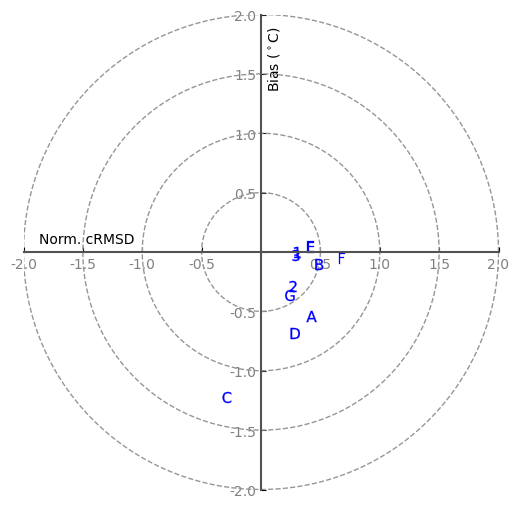

In [106]:


# merge datasets from buoys, LHs

# lh_stats_target_T.append([lh,
#                               rmse_T,
#                               crmse_T,
#                               nrmse_T,
#                               ncrmse_T,
#                               bias_T
#                              ])


Bs = SST_target_np_buoys_and_LH[:,5].astype('f')
RMSDs =  SST_target_np_buoys_and_LH[:,4].astype('f')

#kind = ['+','o','x','s','d','^','v','p','h','*']
# markers?
rcParams["figure.figsize"] = [10.0, 10.0]
msize = 10
medgew1 = 0.2
medgew2 = 0.2
facecolor1 = 'b'
facecolor2 = 'b'
edgecolor1 = 'b'
edgecolor2 = 'b'

ticklabcolor = '#808080'
axesedgecolor = '#525252'

bias_label = "Bias ($^\circ$C)"
RMSD_label = "Norm. cRMSD"
b_lab_rot = 90
rmsd_lab_rot = 0
b_lab_pos_yoffset = -0.5
b_lab_pos_xoffset = 0.18
rmsd_lab_pos_yoffset = 0.1
rmsd_lab_pos_xoffset = -4

# NOTE THIS IS HARDCODING ORDER, assumes same in dataset
# from matplotlib import rc
# rc('text', usetex=True)
o_markerstyle = "font" # added by GO - "font" / "symbol"




# options
axismax = 2 # maximum for the Bias & uRMSD axis max for  X & Y values. Sets default circles when no contours specified (def = 0.0 = none)
ticks = []
xticklabelpos = []
yticklabelpos = []
normalized = 'off'
overlay = 'off' # on / off (not sure if 'on will work')
alpha = 1.0 # 0 = transparent

# circles
circlecols = None #dictionary with two possible colors keys ('ticks','tick_labels') or None
o_circles = [0.5,1,1.5,2.0] # radii of circles to draw
circlelinespec = 'k--'
circlestyle = circlelinespec[1:] # circlelinespec by default
circlelinewidth = 1 # rcParams.get('lines.linewidth')
# circlecolor = circlelinespec[0]
circlecolor = '#969696' #grey
circlelinespec = None
obsuncertainty = 0 # (default of 0)
markerdisplayed = 'marker' # marker / colorbar
o_markersize = 8
o_markersymbol = 'o'
o_markercolor = None # single color to use for all markers (Default: None)
o_markercolors = None  # if None, considers 'markercolor' only; dictionary with two colors as keys ('face', 'edge')
#                                 or None. If None or 'markerlegend' == 'on' then
#                                 considers only the value of 'markercolor'. (Default: None)
o_markerlabelcolor = 'k'
#o_markers = None # dictionary(key (label, stn): faceColor, symbol, size, edgeColor, labelColor)
markerobs = 'none'
stylebias = '-.'
markerlegend = 'on' # on / off
numberpanels = None
face = None # face colors
edge = None # edge colors
cmap = 'jet'
cmap_vmin = None
cmap_vmax = None
cmap_marker = 'd'
cmapzdata = []
colframe = '#000000' # black
colormap = 'on'
equalaxes = 'on'
labelweight = 'bold' # weight of the x/y labels ('light', 'normal', 'bold', ...)
locationcolorbar = 'NorthOutside' # 'NorthOutside' or 'EastOutside'
target_options_file = ''
ticks = []
titlecolorbar = ''
xticklabelpos = []
yticklabelpos = []


# function ax, Bs, RMSDs, RMSDz = _get_target_diagram_arguments(*args) -->
# nargin = len(args)
# if nargin == 0:
#     # Display options list
#     _display_target_diagram_options()
#     return [], [], [], []
# elif nargin == 3:
#     bs, rmsds, rmsdz = args
#     CAX = plt.gca()
# elif nargin == 4:
#     CAX, bs, rmsds, rmsdz = args
#     if not hasattr(CAX, 'axes'):
#         raise ValueError('First argument must be a matplotlib axes.')
# else:
#     raise ValueError('Must supply 3 or 4 arguments.')
# del nargin
# Check data validity
# Bs = _ensure_np_array_or_die(bs, "Bs")
# RMSDs = _ensure_np_array_or_die(rmsds, "RMSDs")
# RMSDz = _ensure_np_array_or_die(rmsdz, "RMSDz")
# return CAX, Bs, RMSDs, RMSDz
# end _get_target_diagram_arguments



# Get options
# option = get_target_diagram_options(**kwargs)

### GET AXES #####
# function get_target_diagram_axes(RMSDs,Bs,option) -->
ax = plt.gca()
x = RMSDs; y = Bs

foundmax = 1 if axismax != 0.0 else 0
if foundmax == 0:
    # Axis limit not specified
    maxx = np.amax(np.absolute(x))
    maxy = np.amax(np.absolute(y))
else:
    # Axis limit is specified
    maxx = axismax
    maxy = axismax

# Determine default number of tick marks
xtickvals = ticker.AutoLocator().tick_values(-1.0*maxx, maxx)
ytickvals = ticker.AutoLocator().tick_values(-1.0*maxy, maxy)
nxticks = np.sum(xtickvals > 0)
nyticks = np.sum(ytickvals > 0)

# Set default tick increment and maximum axis values
if foundmax == 0:
    maxx = xtickvals[-1]
    maxy = ytickvals[-1]
    axismax = max(maxx, maxy)

# Check if equal axes requested
if equalaxes == 'on':
    if maxx > maxy:
        maxy = maxx
        nyticks = nxticks
    else:
        maxx = maxy
        nxticks = nyticks

# Convert to integer if whole number
if type(maxx) is float and maxx.is_integer(): maxx = int(round(maxx))
if type(maxx) is float and maxy.is_integer(): maxy = int(round(maxy))
minx = -maxx; miny = -maxy

# Determine tick values
if len(ticks) > 0:
    xtick = ticks; ytick = ticks
else:
    tincx = maxx/nxticks; tincy = maxy/nyticks
    xtick = np.arange(minx, maxx+tincx, tincx)
    ytick = np.arange(miny, maxy+tincy, tincy)

# Assign tick label positions
if len(xticklabelpos) == 0:
    xticklabelpos= xtick
if len(yticklabelpos) == 0:
    yticklabelpos= ytick

#define x offset
thexoffset = find_exp(maxx)

if use_sci_notation(maxx): 
    ixsoffset = True
    xsoffset_str = "$\tx\mathdefault{10^{"+ str(thexoffset) +"}}\mathdefault{}$"
else:
    ixsoffset = False
    xsoffset_str = 'None'

theyoffset = find_exp(maxy)
if use_sci_notation(maxy): 
    iysoffset = True
    ysoffset_str = "$\tx\mathdefault{10^{"+str(theyoffset)+"}}\mathdefault{}$"
else:
    iysoffset = False
    ysoffset_str = 'None'

# Set tick labels using provided tick label positions
xlabel =[]; ylabel = [];

# Set x tick labels
for i in range(len(xtick)):
    index = np.where(xticklabelpos == xtick[i])
    if len(index) > 0:
        thevalue = xtick[i]
        if ixsoffset: 
            thevalue = xtick[i] * (10**(-1*thexoffset))
            label = get_axis_tick_label(thevalue)
            xlabel.append(label)
        else:
            label = get_axis_tick_label(xtick[i])
            xlabel.append(label)
    else:
        xlabel.append('')

# Set tick labels at 0 to blank
# print(xtick)
blank_at_zero(xtick,xlabel)

# Set y tick labels
for i in range(len(ytick)):
    index = np.where(yticklabelpos == ytick[i])
    if len(index) > 0:
        thevalue = ytick[i]
        if iysoffset: 
            thevalue = ytick[i] * (10**(-1*theyoffset)) 
            label = get_axis_tick_label(thevalue)
            ylabel.append(label)
        else:
            label = get_axis_tick_label(ytick[i])
            ylabel.append(label)
    else:
        ylabel.append('')

# Set tick labels at 0 to blank
blank_at_zero(ytick,ylabel)

# Store output variables in data structure
axes = {}
axes['xtick'] = xtick
axes['ytick'] = ytick
axes['xlabel'] = xlabel
axes['ylabel'] = ylabel
axes['xoffset'] = xsoffset_str
axes['yoffset'] = ysoffset_str
# END function get_target_diagram_axes


#### Overlay circles ####
# function overlay_target_diagram_circles(ax: matplotlib.axes.Axes, option: dic) -->
theta = np.arange(0, 2*np.pi, 0.01)
unit = np.ones(len(theta))

# 1 - reference circle if normalized
if normalized == 'on':
    rho = unit
    X, Y = pol2cart(theta, rho)
    ax.plot(X, Y, 'k', 'LineWidth', circleLineWidth)

# Set range for target circles
if normalized == 'on':
    circles = [.5, 1]
else:
    if o_circles is None:
        circles = [axismax * x for x in [.7, 1]]
    else:
        circles = np.asarray(o_circles)
        index = np.where(circles <= axismax)
        circles = [o_circles[i] for i in index[0]]

# 2 - secondary circles
for c in circles:
    rho = c * unit
    X, Y = pol2cart(theta, rho)
    ax.plot(X, Y, linestyle=circlestyle,
            color=circlecolor,
            linewidth=circlelinewidth)
del c

# 3 - Observational Uncertainty threshold
if obsuncertainty > 0:
    rho = obsuncertainty * unit
    X, Y = pol2cart(theta, rho)
    ax.plot(X, Y, '--b')
# END function overlay_target_diagram_circles


# Modify axes for target diagram (no overlay)
# if option['overlay'] == 'off':
#     axes_handles = plot_target_axes(ax, axes)
# function plot_target_axes -->   
if overlay == 'off':    
    axes_handles = []
    fontFamily = rcParams.get('font.family')

    # Center axes location by moving spines of bounding box
    # Note: Center axes location not available in matplotlib
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    # Make axes square
    ax.set_aspect('equal')

    # Set new ticks and tick labels
    ax.set_xticks(axes['xtick'])
    ax.set_xticklabels(axes['xlabel'], fontfamily=fontFamily, color=ticklabcolor)
    ax.set_yticks(axes['ytick'])
    ax.set_yticklabels(axes['ylabel'], fontfamily=fontFamily, color=ticklabcolor)

    # Set axes limits
    axislim = [axes['xtick'][0], axes['xtick'][-1], axes['ytick'][0], axes['ytick'][-1]]
    ax.set_xlim(axislim[0:2])
    ax.set_ylim(axislim[2:])

    # Label x-axis
    fontSize = matplotlib.rcParams.get('font.size')
    xpos = axes['xtick'][-1] + 2*axes['xtick'][-1]/30
    ypos = axes['xtick'][-1]/30
    if axes['xoffset'] == 'None':
       ax.set_xlabel(RMSD_label, fontsize = fontSize, rotation=rmsd_lab_rot)
    else:
       ax.set_xlabel(RMSD_label + '\n(' + axes['xoffset'] + ')', fontsize = fontSize, rotation=rmsd_lab_rot)
    xlabelh = ax.xaxis.get_label()
    xlabelh.set_horizontalalignment('left')
    ax.xaxis.set_label_coords(xpos+rmsd_lab_pos_xoffset, ypos+rmsd_lab_pos_yoffset, transform=ax.transData)
    ax.tick_params(axis='x', direction='in') # have ticks above axis

    # Label y-axis
    xpos = 0
    ypos = axes['ytick'][-1] + 2*axes['ytick'][-1]/30
    if axes['yoffset'] == 'None':        
        ax.set_ylabel(bias_label + ' ', fontsize = fontSize, rotation=b_lab_rot)
    else:
        ax.set_ylabel(bias_label + ' ' + '(' + axes['yoffset'] + ')', fontsize = fontSize, rotation=b_lab_rot)

    ylabelh = ax.yaxis.get_label()
    ylabelh.set_horizontalalignment('center')
    ax.yaxis.set_label_coords(xpos+b_lab_pos_xoffset, ypos+b_lab_pos_yoffset, transform=ax.transData)
    ax.tick_params(axis='y', direction='in') # have ticks on right side of axis

    # Set axes line width
    lineWidth = rcParams.get('lines.linewidth')
    ax.spines['left'].set_linewidth(lineWidth)
    ax.spines['bottom'].set_linewidth(lineWidth)
    
    ax.spines['left'].set_edgecolor(axesedgecolor)
    ax.spines['bottom'].set_edgecolor(axesedgecolor)
    
# END function plot_target_axes -->     

    
###########################
##### plot the markers ####

# Plot data points
# lowcase = markerdisplayed.lower()
# if lowcase == 'marker':
#     plot_pattern_diagram_markers(ax,RMSDs,Bs,option)
# elif lowcase == 'colorbar':
#     plot_pattern_diagram_colorbar(ax,RMSDs,Bs,RMSDz,option)
# else:
#     raise ValueError('Unrecognized option: ' + 
#                      markerdisplayed)

# function plot_pattern_diagram_markers (ax,RMSDs,Biases,option) -->
# must change X to RMSDs, Y to Biases

# Set font and marker size
fontSize = matplotlib.rcParams.get('font.size') - 2

# Check enough labels provided if markerlabel provided. Not a problem if labels
# provided via the markers option.
numberLabel = len(o_markerlabel)
if numberLabel > 0:
    if isinstance(o_markerlabel, list) and numberLabel < len(RMSDs):
        raise ValueError('Insufficient number of marker labels provided.\n' +
                         'target: No. labels=' + str(numberLabel) + ' < No. markers=' +
                         str(len(RMSDs)) + '\n' +
                         'taylor: No. labels=' + str(numberLabel+1) + ' < No. markers=' +
                         str(len(RMSDs)+1))
    elif isinstance(o_markerlabel, dict) and numberLabel > 70: # what is this? GLO why 70?
        raise ValueError('Insufficient number of marker labels provided.\n' +
                         'target: No. labels=' + str(numberLabel) + ' > No. markers= 70')

if markerlegend == 'on':
    # Check that marker labels have been provided
    if o_markerlabel == '' and o_markers == None:
        raise ValueError('No marker labels provided.')

    # Plot markers of different color and symbols with labels displayed in a legend
    limit = axismax
    hp = ()
    rgba = None

    if o_markers is None:
        
        # Define default markers (function)
#         marker, markercolor = get_default_markers(X, option)
        #get_default_markers:
#         alpha = option['alpha']

        # Define list of marker symbols and colros
        kind = ['+','o','x','s','d','^','v','p','h','*']
        colorm = ['r','b','g','c','m','y','k','gray']
        if len(RMSDs) > 80:
            print('You must introduce new markers to plot more than 70 cases.')
            print('The ''marker'' character array need to be extended inside the code.')

        if len(RMSDs) <= len(kind):
            # Define markers with specified color
            marker = []
            markercolor = []
            if o_markercolor is None:
                for i, color in enumerate(colorm):
                    rgba = clr.to_rgb(color) + (alpha,)
                    marker.append(kind[i] + color)
                    markercolor.append(rgba)
            else:
                rgba = clr.to_rgb(o_markercolor) + (alpha,)
                for symbol in kind:
                    marker.append(symbol + o_markercolor)
                    markercolor.append(rgba)
        else:
            # Define markers and colors using predefined list
            marker = []
            markercolor = []
            for color in colorm:
                for symbol in kind:
                    marker.append(symbol + color)
                    rgba = clr.to_rgb(color) + (alpha,)
                    markercolor.append(rgba)
        # END get_default_markers
                   
                   
        # Plot markers at data points
        labelcolor = []
        markerlabel = []
        for i, xval in enumerate(RMSDs):
            if abs(RMSDs[i]) <= limit and abs(Bs[i]) <= limit:
                h = ax.plot(RMSDs[i],
                            Bs[i],
                            marker[i], 
                            markersize = o_markersize,
                            markerfacecolor = markercolor[i],
                            markeredgecolor = markercolor[i][0:3] + (1.0,),
                            markeredgewidth = 1)
                hp += tuple(h)
                labelcolor.append(o_markerlabelcolor)
                markerlabel.append(o_markerlabel[i])

    # if there's an o_markers dictionary
    else:
        # Obtain markers from option['markers']
        #labels, labelcolor, marker, markersize, markerfacecolor, markeredgecolor = \
            #get_single_markers(option['markers'])

        #get_single_markers -->
        if o_markers is None:
            raise ValueError("Empty dictionary provided for option['markers']")

        labelcolor = []
        marker = []
        markerfacecolor = []
        markeredgecolor = []
        markerlabel = []
        markersize = []
        markeredgewidth = []
        
#         if o_markerstyle == "font":
#             marker_style.update(markeredgecolor="none", markersize=15)

        # Iterate through keys in dictionary
        for key in o_markers:
            color = o_markers[key]['facecolor']
            symbol = o_markers[key]['symbol']
            
            if o_markerstyle != "font":
                SymbolColor = symbol + color
                marker.append(SymbolColor)
            else:
                marker.append(symbol)
                fontFamily = rcParams.get('font.family')
            
            markersize.append(o_markers[key]['size'])
            markerfacecolor.append(color)
            markeredgecolor.append(o_markers[key]['edgecolor'])
            markeredgewidth.append(o_markers[key]['edgewidth'])
            markerlabel.append(key) # store label
            labelcolor.append(o_markers[key]['labelcolor'])
        # end get_single_markers
        
        # Plot markers at data points
        for i, xval in enumerate(RMSDs):
            if abs(RMSDs[i]) <= limit and abs(Bs[i]) <= limit:
                h = ax.plot(RMSDs[i],
                            Bs[i],
                            marker=marker[i],
                            markersize = markersize[i],
                            markerfacecolor = markerfacecolor[i],
                            markeredgecolor = markeredgecolor[i],
                            markeredgewidth = markeredgewidth[i])
                hp += tuple(h)
                #markerlabel.append(labels[i])

    # Add legend
    if len(markerlabel) == 0:
        warnings.warn('No markers within axis limit ranges.')
    else:
        
        #add_legend(markerlabel, labelcolor, option, rgba, markerSize, fontSize, hp)          
        # add_legend --> 
        if type(markerlabel) is list:

            # Check for empty list of plot handles
            if len(hp) == 0:
                raise ValueError('Empty list of plot handles')
            elif len(hp) != len(markerlabel):
                raise ValueError('Number of labels and plot handle do not match: ' +
                                 str(len(markerlabel)) + ' != ' + str(len(hp)))

            # Add legend using labels provided as list
            if len(markerlabel) <= 6:
                # Put legend in a default location
                markerlabel_tu = tuple(markerlabel)
                leg = plt.legend(hp, markerlabel_tu, loc = 'upper right',
                                     fontsize = fontSize, numpoints=1,
                                     bbox_to_anchor=(1.2,1.0))
            else:
                # Put legend to right of the plot in multiple columns as needed

                nmarkers = len(markerlabel)
                ncol = int(math.ceil(nmarkers / 15.0))
                markerlabel_tu = tuple(markerlabel)

                # Shift figure to include legend
                plt.gcf().subplots_adjust(right=0.6)

                # Plot legend of multi-column markers
                # Note: do not use bbox_to_anchor as this cuts off the legend
                if circlelinespec != None:
                    loc = (1.2, 0.25)
                else:    
                    #loc = (1.1, 0.25)
                    loc = (1.1, 0.75)
                    
#                 leg = plt.legend(hp, markerlabel_tu, loc = loc, fontsize = fontSize,
#                                  numpoints=1, ncol = ncol)

        elif type(markerlabel) is dict:

            # Add legend using labels provided as dictionary

            # Define legend elements
            legend_elements = []
            for key, value in markerlabel.items():
                legend_object = Line2D([0], 
                                       [0], 
                                       marker='.', 
                                       markersize = markerSize,
                                       markerfacecolor = rgba,
                                       markeredgecolor = value,
                                       label=key,
                                       linestyle='')
                legend_elements.append(legend_object)

            # Put legend in a default location
            leg = plt.legend(handles=legend_elements, loc = 'upper right',
                                 fontsize = fontSize, numpoints=1,
                                 bbox_to_anchor=(1.2,1.0))

            if numberpanels != None and numberpanels == 2:
                # add padding so legend is not cut off
                plt.tight_layout(pad=1)
        else:
            raise Exception('markerLabel type is not a list or dictionary: ' + 
                            str(type(markerlabel)))

        # Set color of text in legend
        for i, text in enumerate(leg.get_texts()):
            text.set_color(labelcolor[i])
        # end add_legend

# if no legend        
else:
    # Plot markers as dots of a single color with accompanying labels

    # Plot markers at data points
    limit = axismax

    # Define edge and face colors of the markers
    #                                             default_key, dict_key, key_key
    #edge_color = get_from_dict_or_default(option, 'markercolor', 'markercolors', 'edge')
    # get_from_dict_or_default ->
    if markercolors is None:
        edge_color = markercolor
    elif edge is None:
        edge_color = markercolor
    elif edge != None:
        edge_color = edge
    # end get_from_dict_or_default
    
    if edge_color is None: edge_color = 'r'
        
    #face_color = get_from_dict_or_default(option, 'markercolor', 'markercolors', 'face')
    # get_from_dict_or_default ->
    if markercolors is None:
        face_color = markercolor
    elif face is None:
        face_color = markercolor
    elif face != None:
        face_color = face
    # end get_from_dict_or_default
    
    if face_color is None: face_color = edge_color
    face_color = clr.to_rgb(face_color) + (alpha,)

    labelcolor = []
    for i in range(len(RMSDs)):
        xval, yval = RMSDs[i], Bs[i]
        if abs(xval) <= limit and abs(yval) <= limit:
            ax.plot(xval, yval, markersymbol,markersize=markersize, markerfacecolor=face_color,markeredgecolor=edge_color)
            labelcolor.append(markerlabelcolor)

            # Check if marker labels provided
            if type(markerlabel) is list:
                # Label marker
                ax.text(xval, yval, markerlabel[i],color=markerlabelcolor,verticalalignment='bottom',horizontalalignment='right',fontsize=fontSize)

        del i, xval, yval

    # Add legend if labels provided as dictionary
    marker_label_color = clr.to_rgb(edge_color) + (alpha,)
    if type(markerlabel) is dict:
        add_legend(markerlabel, labelcolor, option, marker_label_color, markerSize, fontSize)
        
# END plot_pattern_diagram_markers

In [87]:
markerlabel

['Active Pass',
 'Cape Mudge',
 'Chrome Is.',
 'Entrance Is.',
 'Race Rocks',
 'Sheringham Pt.',
 'Sisters Islets',
 'ptaw1',
 'ptww1',
 'tcnw1',
 '46087',
 '46088',
 '46131',
 '46146',
 'neaw1',
 '46134']

In [433]:
SST_stats_np_buoys_and_LH[:,4:5]

array([['0.419384174532246'],
       ['0.4774523093990656'],
       ['-0.29429282410530283'],
       ['0.27616058252792053'],
       ['0.41341168140745416'],
       ['0.6702700370541785'],
       ['0.23563086682752257'],
       ['1.0881950220945587'],
       ['1.4327303656869155'],
       ['1.051291541205516'],
       ['0.4947538870228493'],
       ['0.4388157393000552'],
       ['0.2940835761237354'],
       ['0.3026738579463872'],
       ['0.7019373901010536']], dtype='<U32')

# SCRAPS BELOW

In [555]:
# trying to minimize code from SM

#symbol options  = ['+','o','x','s','d','^','v','p','h','*']
#color options  = ['r','b','g','c','m','y','k','gray']

o_markers = {'Active Pass': {'symbol':'+',
                             'size': 5,
                             'facecolor': 'r',
                             'edgecolor': 'b',
                            'labelcolor': 'b'},
             'Cape Mudge': {'symbol':'+',
                             'size': 5,
                             'facecolor': 'r',
                             'edgecolor': 'b',
                            'labelcolor': 'b'},
             'Chrome Is.': {'symbol':'+',
                             'size': 5,
                             'facecolor': 'r',
                             'edgecolor': 'b',
                            'labelcolor': 'b'},
             'Entrance Is.': {'symbol':'+',
                             'size': 5,
                             'facecolor': 'r',
                             'edgecolor': 'b',
                            'labelcolor': 'b'},
            }


###### GET AXES ######
### GET AXES #####
# function get_target_diagram_axes(RMSDs,Bs,option) -->
x = RMSDs; y = Bs

foundmax = 1 if axismax != 0.0 else 0
if foundmax == 0:
    # Axis limit not specified
    maxx = np.amax(np.absolute(x))
    maxy = np.amax(np.absolute(y))
else:
    # Axis limit is specified
    maxx = axismax
    maxy = axismax

# default number of tick marks
xtickvals = ticker.AutoLocator().tick_values(-1.0*maxx, maxx)
ytickvals = ticker.AutoLocator().tick_values(-1.0*maxy, maxy)
nxticks = np.sum(xtickvals > 0)
nyticks = np.sum(ytickvals > 0)

# default tick increment and maximum axis values
if foundmax == 0:
    maxx = xtickvals[-1]
    maxy = ytickvals[-1]
    axismax = max(maxx, maxy)

# Check if equal axes requested
if equalaxes == 'on':
    if maxx > maxy:
        maxy = maxx
        nyticks = nxticks
    else:
        maxx = maxy
        nxticks = nyticks

# Convert to integer if whole number
if type(maxx) is float and maxx.is_integer(): maxx = int(round(maxx))
if type(maxx) is float and maxy.is_integer(): maxy = int(round(maxy))
minx = -maxx; miny = -maxy

# Determine tick values
if len(ticks) > 0:
    xtick = ticks
    ytick = ticks
else:
    tincx = maxx/nxticks
    tincy = maxy/nyticks
    xtick = np.arange(minx, maxx+tincx, tincx)
    ytick = np.arange(miny, maxy+tincy, tincy)

# Assign tick label positions
if len(xticklabelpos) == 0:
    xticklabelpos= xtick
if len(yticklabelpos) == 0:
    yticklabelpos= ytick

#define x offset
thexoffset = find_exp(maxx)

if use_sci_notation(maxx): 
    ixsoffset = True
    xsoffset_str = "$\tx\mathdefault{10^{"+ str(thexoffset) +"}}\mathdefault{}$"
else:
    ixsoffset = False
    xsoffset_str = 'None'

theyoffset = find_exp(maxy)
if use_sci_notation(maxy): 
    iysoffset = True
    ysoffset_str = "$\tx\mathdefault{10^{"+str(theyoffset)+"}}\mathdefault{}$"
else:
    iysoffset = False
    ysoffset_str = 'None'

# Set tick labels using provided tick label positions
xlabel =[]; ylabel = [];

# Set x tick labels
for i in range(len(xtick)):
    index = np.where(xticklabelpos == xtick[i])
    if len(index) > 0:
        thevalue = xtick[i]
        if ixsoffset: 
            thevalue = xtick[i] * (10**(-1*thexoffset))
            label = get_axis_tick_label(thevalue)
            xlabel.append(label)
        else:
            label = get_axis_tick_label(xtick[i])
            xlabel.append(label)
    else:
        xlabel.append('')

# Set tick labels at 0 to blank
# print(xtick)
blank_at_zero(xtick,xlabel)

# Set y tick labels
for i in range(len(ytick)):
    index = np.where(yticklabelpos == ytick[i])
    if len(index) > 0:
        thevalue = ytick[i]
        if iysoffset: 
            thevalue = ytick[i] * (10**(-1*theyoffset)) 
            label = get_axis_tick_label(thevalue)
            ylabel.append(label)
        else:
            label = get_axis_tick_label(ytick[i])
            ylabel.append(label)
    else:
        ylabel.append('')

# Set tick labels at 0 to blank
blank_at_zero(ytick,ylabel)

# Store output variables in data structure
axes = {}
axes['xtick'] = xtick
axes['ytick'] = ytick
axes['xlabel'] = xlabel
axes['ylabel'] = ylabel
axes['xoffset'] = xsoffset_str
axes['yoffset'] = ysoffset_str
# END function get_target_diagram_axes




######## CIRCLES ########
# function overlay_target_diagram_circles(ax: matplotlib.axes.Axes, option: dic) -->
theta = np.arange(0, 2*np.pi, 0.01)
unit = np.ones(len(theta))

# 1 - reference circle if normalized
if normalized == 'on':
    rho = unit
    X, Y = pol2cart(theta, rho)
    ax.plot(X, Y, 'k', 'LineWidth', circleLineWidth)

# Set range for target circles
if normalized == 'on':
    circles = [.5, 1]
else:
    if o_circles is None:
        circles = [axismax * x for x in [.7, 1]]
    else:
        circles = np.asarray(o_circles)
        index = np.where(circles <= axismax)
        circles = [o_circles[i] for i in index[0]]

# 2 - secondary circles
for c in circles:
    rho = c * unit
    X, Y = pol2cart(theta, rho)
    ax.plot(X, Y, linestyle=circlestyle,
            color=circlecolor,
            linewidth=circlelinewidth)
del c

# 3 - Observational Uncertainty threshold
# if obsuncertainty > 0:
#     rho = obsuncertainty * unit
#     X, Y = pol2cart(theta, rho)
#     ax.plot(X, Y, '--b')
# END function overlay_target_diagram_circles








#### PLOT MARKERS ####
labelcolor = []
marker = []
markerfacecolor = []
markeredgecolor = []
markerlabel = []
markersize = []

# Iterate through keys in dictionary
for key in o_markers:
    color = o_markers[key]['facecolor']
    symbol = o_markers[key]['symbol']
    SymbolColor = symbol + color
    marker.append(SymbolColor)
    markersize.append(o_markers[key]['size'])
    markerfacecolor.append(color)
    markeredgecolor.append(o_markers[key]['edgecolor'])
    markerlabel.append(key) # store label
    labelcolor.append(o_markers[key]['labelcolor'])
# end get_single_markers

# Plot markers at data points
for i, xval in enumerate(RMSDs):
    if abs(RMSDs[i]) <= limit and abs(Bs[i]) <= limit:
        h = ax.plot(RMSDs[i],
                    Bs[i],
                    marker[i],
                    markersize = markersize[i],
                    markerfacecolor = markerfacecolor[i],
                    markeredgecolor = markeredgecolor[i],
                    markeredgewidth = 2)
        hp += tuple(h)
        #markerlabel.append(labels[i])

        
###### LEGEND #####
legend_elements = []
# for key, value in markerlabel.items():
#     legend_object = Line2D([0], 
#                            [0], 
#                            marker='.', 
#                            markersize = markerSize,
#                            markerfacecolor = rgba,
#                            markeredgecolor = value,
#                            label=key,
#                            linestyle='')
#     legend_elements.append(legend_object)

# # Put legend in a default location
# leg = plt.legend(handles=legend_elements, loc = 'upper right',
#                      fontsize = fontSize, numpoints=1,
#                      bbox_to_anchor=(1.2,1.0))


    
    
# Add legend using labels provided as list
if len(markerlabel) <= 6:
    # Put legend in a default location
    markerlabel_tu = tuple(markerlabel)
    leg = plt.legend(hp, markerlabel_tu, loc = 'upper right',
                         fontsize = fontSize, numpoints=1,
                         bbox_to_anchor=(1.2,1.0))
else:
    # Put legend to right of the plot in multiple columns as needed

    nmarkers = len(markerlabel)
    ncol = int(math.ceil(nmarkers / 15.0))
    markerlabel_tu = tuple(markerlabel)

    # Shift figure to include legend
    plt.gcf().subplots_adjust(right=0.6)

    # Plot legend of multi-column markers
    # Note: do not use bbox_to_anchor as this cuts off the legend
    if 'circlelinespec' in option:
        loc = (1.2, 0.25)
    else:
        loc = (1.1, 0.25)
    leg = plt.legend(hp, markerlabel_tu, loc = loc, fontsize = fontSize,
                     numpoints=1, ncol = ncol)

    
    
if numberpanels != None and numberpanels == 2:
    # add padding so legend is not cut off
    plt.tight_layout(pad=1)

IndexError: list index out of range

C:\Users\Greig\AppData\Local\Temp\ipykernel_13508\1907565894.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', '0', '', 'π/4', '', 'π/2', '', '3π/4', ''])


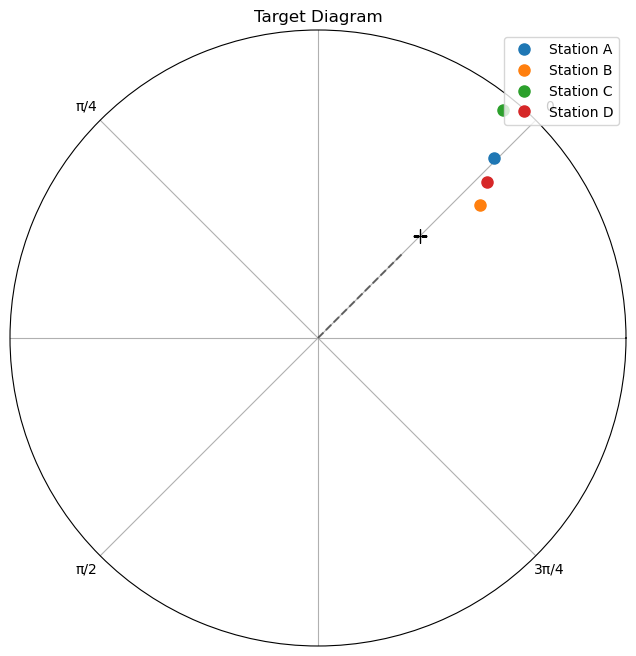

In [457]:
# attempt using chatgpt

import matplotlib.pyplot as plt
import numpy as np

# Example data
stations = ['Station A', 'Station B', 'Station C', 'Station D']
model_bias = [0.1, -0.2, 0.05, 0.15]
crmse = [0.5, 0.4, 0.6, 0.45]
rmse = [0.6, 0.5, 0.7, 0.55]

# Define the reference values (e.g., observations)
ref_bias = 0.0
ref_crmse = np.mean(crmse)
ref_rmse = np.mean(rmse)


# Create the 'target' diagram
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, polar=True)

# Plot the reference points
ax.plot([0, np.arctan(1)], [0, ref_crmse], 'k--', alpha=0.5)  # Reference CRMSE line
ax.plot(np.arctan(1), ref_rmse, 'k+', markersize=10)  # Reference RMSE point

# Plot the model points
for i in range(len(stations)):
    angle = np.arctan(crmse[i] / ref_crmse)
    distance = rmse[i] / ref_rmse
    ax.plot(angle, distance, 'o', markersize=8, label=stations[i])

# Add labels and legend
ax.set_xticklabels(['', '0', '', 'π/4', '', 'π/2', '', '3π/4', ''])
ax.set_yticklabels([])
ax.set_rticks([])
ax.set_title('Target Diagram')
ax.legend(loc='upper right')

plt.show()


In [ ]:
# using example code snipped 
import skillmetrics as sm
# Read data from CSV files

ex_path = '../data/temp/skillmetricsexample'
data_files = [os.path.join(ex_path,'pred1.csv'), os.path.join(ex_path,'pred2.csv'), os.path.join(ex_path,'pred3.csv'), os.path.join(ex_path,'ref.csv')]
data = load_data(data_files)

# Calculate statistics for Taylor diagram
# The first array element (e.g. taylor_stats1[0]) corresponds to the 
# reference series while the second and subsequent elements
# (e.g. taylor_stats1[1:]) are those for the predicted series.
taylor_stats1 = sm.taylor_statistics(data['../data/temp/skillmetricsexample\\pred1'],data['../data/temp/skillmetricsexample\\ref'],'data',norm=True)
taylor_stats2 = sm.taylor_statistics(data['../data/temp/skillmetricsexample\\pred2'],data['../data/temp/skillmetricsexample\\ref'],'data',norm=True)
taylor_stats3 = sm.taylor_statistics(data['../data/temp/skillmetricsexample\\pred3'],data['../data/temp/skillmetricsexample\\ref'],'data',norm=True)

# Store statistics in arrays
sdev = np.array([taylor_stats1['sdev'][0], taylor_stats1['sdev'][1], 
                 taylor_stats2['sdev'][1], taylor_stats3['sdev'][1]])
crmsd = np.array([taylor_stats1['crmsd'][0], taylor_stats1['crmsd'][1], 
                  taylor_stats2['crmsd'][1], taylor_stats3['crmsd'][1]])
ccoef = np.array([taylor_stats1['ccoef'][0], taylor_stats1['ccoef'][1], 
                  taylor_stats2['ccoef'][1], taylor_stats3['ccoef'][1]])

'''
Produce the Taylor diagram

Note that the first index corresponds to the reference series for 
the diagram. For example sdev[0] is the standard deviation of the 
reference series and sdev[1:4] are the standard deviations of the 
other 3 series. The value of sdev[0] is used to define the origin 
of the RMSD contours. The other values are used to plot the points 
(total of 3) that appear in the diagram.

For an exhaustive list of options to customize your diagram, 
please call the function at a Python command line:
>> taylor_diagram
'''
sm.taylor_diagram(sdev,crmsd,ccoef)

In [ ]:
ys.path.append('C:/Users/Greig/Documents/GitHub/SkillMetrics_glo')

import matplotlib.pyplot as plt
import skill_metrics as sm

# remove these eventually - GO
# these are from the /examples folder in Skill metrics

def load_data(filenames : list) -> dict:
    '''
    Reads data from Comma, Separated, Value (CSV) files and returns them in dictionary objects.
    
    This function accepts a list of CSV filenames and returns a dictionary containing the 
    contents of all the files. Each key in the dictionary is the prefix of the filename, 
    e.g. pred1 for a file named pred1.csv, so for a returned dictionary named "data" this 
    would be data['pred1']. 
    
    The contents of the file are stored as lists in the dictionary, so for a column named
    'data' in the CSV file example above, the data would be accessed using 
    data['pred1']['data']. 
     
    INPUTS:
    filenames : list of CSV filenames, e.g.
                filenames = ['pred1.csv', 'pred2.csv', 'pred3.csv', 'ref.csv']
    
    OUTPUTS:
    data : dictionary containing keys of dictionaries of the data in the CSV files
    The CSV file format must conform to that described in the read_element_data function. An 
    example of the format for the contents of a CSV file is 
    
    data        latitude    longitude    depth    jday            units
    52.9110002  43.161833   -69.576667   -1       3045.255556     cell/L
    1.431675565 43.161833   -69.576667   -10      3045.255556     cell/L
    1.280270828 43.161833   -69.576667   -20      3045.255556     cell/L
    ...
    0.391304068 42.964333   -69.7645     -20      3045.979861     cell/L
    0.360104567 42.964333   -69.7645     -30      3045.979861     cell/L
[56 rows x 7 columns]
    Created on Sep 10, 2022
    Revised on Sep 10, 2022
    
    Author: Peter A. Rochford
        rochford.peter1@gmail.com
    '''
    
    # Create empty dictionary
    data = {}
    
    # Process list of filenames
    for name in filenames:
        # Read data from provided CSV file
        csv_data = read_csv_data(name)
        
        # Convert pandas data frame to dictionary
        dict_data = csv_data.to_dict('list')

        # Get prefix of file name
        file_name, file_extension = os.path.splitext(name)
        
        # Store data as key in dictionary
        data[file_name] = dict_data
        
        del csv_data, dict_data
    
    return data

def read_csv_data(name) -> pd.DataFrame:
    '''
    Read data from a Comma Separated Value (CSV) file. 
    Input:
    name : name of CSV file with or without suffix, e.g. pred1.csv or pred1. 
    Output:
    objectData : data contained in CSV file as a two-dimensional data structure with labeled axes
    
    The data format of objectData is a DataFrame as provided by the pandas.read_csv function. An 
    example of the format for the contents of a CSV file is 
    
          hour   t(sec)   Frequency  ...        PShaft  dSpeed (Deg/sec)  dTheta (Deg)
0        0    0.001     60.0000  ...  2.000000e+09         -0.000093 -9.000000e-10
1        0    0.002     60.0000  ...  2.000000e+09         -0.000093 -2.430000e-09
2        0    0.003     60.0000  ...  2.000000e+09         -0.000093 -4.040000e-09
3        0    0.004     60.0000  ...  2.000000e+09         -0.000093 -5.660000e-09
4        0    0.005     60.0000  ...  2.000000e+09         -0.000093 -7.280000e-09
...    ...      ...         ...  ...           ...               ...           ...
4979     0    4.980     60.4106  ...  2.000000e+09       -575.187000  2.579670e+00
4980     0    4.981     60.4090  ...  2.000000e+09       -576.661000  2.569620e+00
4981     0    4.982     60.4074  ...  2.000000e+09       -578.108000  2.559550e+00
4982     0    4.983     60.4058  ...  2.000000e+09       -579.527000  2.549440e+00
4983     0    4.984     60.4041  ...  2.000000e+09       -580.918000  2.539320e+00
[4984 rows x 8 columns]
    Author: Peter A. Rochford
            rochford.peter1@gmail.com
    
    Created on Apr 22, 2022
    '''

    # Check if CSV file suffix
    file_name, file_extension = os.path.splitext(name)
    
    if file_extension == "":
        filename = name + '.csv'
    elif name.endswith('.csv'):
        filename = name
    else:
        raise Exception("Invalid file type: " + name)
    
    # Check if file exists
    if not os.path.isfile(filename):
        raise Exception("File does not exist: " + filename)
        
    # Load object from CSV file
    objectData = pd.read_csv(filename)
    
    return objectData

In [ ]:
# target diagram
# stn, rmse, crmse, nrmse, ncrmse, bias


rcParams["figure.figsize"] = [8.0, 8.0]

bias = np.array(lh_stats_target_T_np[:,5], dtype='f')
ncrmse = np.array(lh_stats_target_T_np[:,4], dtype='f')
nrmse = np.array(lh_stats_target_T_np[:,3], dtype='f')
print(nrmse)

# buoy_stats_target_np
# label = {'ERA-5': 'r', 'TRMM': 'b'}
label = lh_stats_target_T_np[:,0]
print(ncrmse)
sm.target_diagram(bias,ncrmse,nrmse,#normalized ='on',
                  #markers = MARKERS, 
                  markercolor='r',
                  markerLegend = 'on', 
                  markerLabel = label.tolist(),
                  markersize = 6,
                  ticks = np.arange(-2,2.5,0.5),
                  #labelWeight = 4,
                  axismax = 50.0, 
                  circles = [0.5,1,1.5, 2], 
                  circleLineSpec = 'b-.', 
                  circleLineWidth = 1,
                  circleStyle='-',
                  circleColor='#969696')

# stats from buoys = temp only
bias = np.array(buoy_stats_target_np[:,5], dtype='f')
ncrmse = np.array(buoy_stats_target_np[:,4], dtype='f')
nrmse = np.array(buoy_stats_target_np[:,3], dtype='f')
label = buoy_stats_target_np[:,0]
sm.target_diagram(bias,crmsd,rmsd,#normalized ='on',
                  #markers = MARKERS, 
                  markercolor='b',
                  markerLegend = 'on', 
                  markerLabel = label.tolist(),
                  markersize = 6,
                  ticks = np.arange(-2,2.5,0.5),
                  #labelWeight = 4,
                  axismax = 50.0, 
                  circles = [0.5,1,1.5, 2], 
                  circleLineSpec = 'b-.', 
                  circleLineWidth = 0.1,
                  circleStyle='-',
                  circleColor='#969696'
                 )

#     _disp('Diagram options:')
#     _dispopt("'alpha'","Blending of symbol face color (0.0 transparent through 1.0 opaque)" +
#              "\n\t\t" + "(Default: 1.0)")
#     _dispopt("'circles'",'Define the radii of circles to draw ' +
#             '(default of (maximum RMSDs)*[.7 1], [.7 1] when normalized diagram)')
#     _dispopt("'circleColor'",'Circle line color specification (default None)')
#     _dispopt("'circleCols'","Dictionary with two possible colors keys ('ticks'," +
#              "'tick_labels')" +
#              "\n\t\t or None, if None then considers only the value of 'circlecolor'" +
#              "(Default: None)")
#     _dispopt("'circleLineSpec'",'Circle line specification (default ' +
#             "dashed black, '--k')")
#     _dispopt("'circleLineWidth'",'Circle line width')
#     _dispopt("'circleStyle'",'Line style for circles, e.g. "--" (Default: None)')
#     _dispopt("'normalized'","'on' / 'off' (default): normalized target diagram")
#     _dispopt("'obsUncertainty'",'Observational Uncertainty (default of 0)')

In [ ]:
# temperature

# to display multiple on one fig, must normalize to reference 
# (std_dev = 1, ccoef = 1, rmse = 0)
#lh, obs_std, mod_std, mod_norm_std, crmse, ncrmse, pears
sdev = np.array(np.concatenate(([1],lh_stats_taylor_T_np[:,3])), dtype='f')
crmsd = np.array(np.concatenate(([0],lh_stats_taylor_T_np[:,5])), dtype='f')
ccoef = np.array(np.concatenate(([1],lh_stats_taylor_T_np[:,6])), dtype='f')

# expects 1-d array with first index from the reference data
#sm.taylor_diagram(sdev,crmsd,ccoef)
label = {'LH': 'r', 'Buoy': 'b'}


# specify some styles for the correlation component
COLS_COR = {
    'grid': '#969696',
    'tick_labels': '#000000',
    'title': '#000000'
}

STYLES_RMS = {
    'color': '#969696',
    'linestyle': '--'
}


'''
Produce the Taylor diagram for the first dataset
'''
sm.taylor_diagram(sdev,crmsd,ccoef, 
                  markercolor ='r', 
                  alpha = 0.0,
                  titleRMS = 'on', 
                  showlabelsRMS = 'on', 
                  tickRMS =[0.5,1.0,1.5],
                  widthRMS = 1.0,
                  colRMS = STYLES_RMS['color'],
                  styleRMS = '-',
                  colscor = COLS_COR,
                  widthcor = 1.0,
                  stylecor = '-'
                 )

'''
Overlay the second dataset
'''
sdev = np.array(np.concatenate(([1],buoy_stats_taylor_np[:,3])), dtype='f')
crmsd = np.array(np.concatenate(([0],buoy_stats_taylor_np[:,5])), dtype='f')
ccoef = np.array(np.concatenate(([1],buoy_stats_taylor_np[:,6])), dtype='f')

sm.taylor_diagram(sdev,crmsd,ccoef, 
                  markercolor ='b', alpha = 0.0,
                  overlay = 'on', markerLabel = label)

#         sm.taylor_diagram(ax,
#                           np.asarray((stdev, stdev)), 
#                           np.asarray((crmsd, crmsd)), 
#                           np.asarray((ccoef, ccoef)),
#                           markercolors = {
#                               "face": MARKERS["Observed"]["color_edge"],
#                               "edge": MARKERS["Observed"]["color_face"]
#                               },
#                           markersize = MARKERS["Observed"]["markersize"],
#                           markersymbol = MARKERS["Observed"]["marker"],
#                           styleOBS = ':',
#                           colOBS = MARKERS["Observed"]["color_edge"],
#                           alpha = 1.0,
#                           titleSTD = 'off',
#                           titleRMS = 'off',
#                           showlabelsRMS = 'on',
#                           tickRMS = [10, 20, 30],
#                           colRMS = STYLES_RMS['color'],
#                           tickRMSangle = 115,
#                           styleRMS = STYLES_RMS['linestyle'],
#                           colscor = COLS_COR,
#                           colsstd = COLS_STD,
#                           styleCOR='-',
#                           styleSTD='-',
#                           colframe='#DDDDDD',
#                           labelweight='normal',
#                           titlecorshape='linear')

# INPUTS:
#     CORs : values of correlations
        
#     OUTPUTS:
#     option : dictionary containing option values
#     option['alpha']           : blending of symbol face color (0.0 
#                                 transparent through 1.0 opaque). (Default : 1.0)
#     option['axismax']         : maximum for the radial contours
#     option['checkstats']      : Check input statistics satisfy Taylor 
#                                 relationship (Default : 'off')
#     option['cmap']            : Choice of colormap. (Default : 'jet')
#     option['cmap_vmin']       : minimum range of colormap (Default : None)
#     option['cmap_vmax']       : maximum range of colormap (Default : None)
#     option['cmap_marker']     : maximum range of colormap (Default : None)
#     option['cmapzdata']       : data values to use for color mapping of
#                                 markers, e.g. RMSD or BIAS. (Default empty)
                                
#     option['colcor']          : color for correlation coefficient labels (Default : blue)
#     option['colscor']         : dictionary with two possible colors as keys ('grid',
#                                 'tick_labels') or None, if None then considers only the
#                                 value of 'colscor' (Default: None)
#     option['colframe']        : color for the y (left) and x (bottom) spines
#     option['colobs']          : color for observation labels (Default : magenta)
#     option['colormap']        : 'on'/'off' switch to map color shading of
#                                  markers to CMapZData values ('on') or min to
#                                  max range of CMapZData values ('off').
#                                  (Default : 'on')
#     option['colrms']          : color for RMS labels (Default : medium green)
#     option['colstd']          : color for STD labels (Default : black)
#     option['colsstd']         : dictionary with two possible colors keys ('ticks',
#                                 'tick_labels') or None, if None then considers only the
#                                 value of 'colstd' (Default: None)
#     option['labelrms']        : RMS axis label (Default: 'RMSD')
#     option['labelweight']     : weight of the x/y/angular axis labels
#     option['locationcolorbar']: location for the colorbar, 'NorthOutside' or
#                                  'EastOutside'

#     option['markercolor']     : single color to use for all markers (Default: None)
#     option['markercolors']    : dictionary with two colors as keys ('face', 'edge')
#                                 or None. If None or 'markerlegend' == 'on' then
#                                 considers only the value of 'markercolor'. (Default: None)
#     option['markerdisplayed'] : markers to use for individual experiments
#     option['markerlabel']     : name of the experiment to use for marker
#     option['markerlabelcolor']: marker label color (Default: 'k')
#     option['markerlegend']    : 'on'/'off' switch to display marker legend
#                                 (Default 'off')
#     option['markerobs']       : marker to use for x-axis indicating observed 
#                                 STD. A choice of 'none' will suppress 
#                                 appearance of marker. (Default 'none')
#     option['markers']         : Dictionary providing individual control of the marker
#                                key - text label for marker, e.g. '14197'
#                                key['labelColor'] - color of marker label, e.g. 'r' for red
#                                key['symbol'] - marker symbol, e.g. 's' for square
#                                key['size'] - marker size, e.g. 9
#                                key['faceColor'] - marker face color, e.g. 'b' for blue
#                                key['edgeColor'] - marker edge color, e.g. 'k' for black line
#                                (Default: None)
#     option['markersize']      : marker size (Default 10)
#     option['markersymbol']    : marker symbol (Default '.')

#     option['numberpanels']    : Number of panels to display
#                                 = 1 for positive correlations
#                                 = 2 for positive and negative correlations
#                                (Default value depends on correlations (CORs))

#     option['overlay']         : 'on'/'off' switch to overlay current
#                                  statistics on Taylor diagram (Default 'off')
#                                  Only markers will be displayed.
#     option['rincrms']         : axis tick increment for RMS values
#     option['rincstd']         : axis tick increment for STD values
#     option['rmslabelformat']  : string format for RMS contour labels, e.g. '0:.2f'.
#                                 (Default '0', format as specified by str function)
 
#     option['showlabelscor']   : show correlation coefficient labels 
#                                 (Default: 'on')
#     option['showlabelsrms']   : show RMS labels (Default: 'on')
#     option['showlabelsstd']   : show STD labels (Default: 'on')

#     option['stylecor']        : line style for correlation coefficient grid 
#                                 lines (Default: dash-dot '-.')
#     option['styleobs']        : line style for observation grid line. A choice of
#                                 empty string '' will suppress appearance of the
#                                 grid line (Default: '')
#     option['stylerms']        : line style for RMS grid lines 
#                                 (Default: dash '--')
#     option['stylestd']        : line style for STD grid lines 
#                                 (Default: dotted ':')

#     option['taylor_options_file'] name of CSV file containing values for optional
#                                 arguments of the taylor_diagram function. If no file
#                                 suffix is given, a ".csv" is assumed. (Default: empty string '')

#     option['tickcor'][panel]  : tick values for correlation coefficients for
#                                 two types of panels
#     option['tickrms']         : RMS values to plot grid circles from
#                                 observation point 
#     option['tickstd']         : STD values to plot grid circles from origin 
#     option['tickrmsangle']    : tick RMS angle (Default: 135 degrees)
#     option['titleColorBar']   : title for the colorbar
#     option['titlecor']        : show correlation coefficient axis label 
#                                 (Default: 'on')
#     option['titlecorshape']   : defines the shape of the label "correlation coefficient"
#                                 as either 'curved' or 'linear' (Default: 'curved')
#     option['titleobs']        : label for observation point (Default: '')
#     option['titlerms']        : show RMS axis label (Default: 'on')
#     option['titlestd']        : show STD axis label (Default: 'on')
#     option['titlermsdangle']  : angle at which to display the 'RMSD' label for the RMS contours
#                                 (Default: 160 degrees)
 
#     option['widthcor']        : linewidth for correlation coefficient grid 
#                                 lines (Default: .8)
#     option['widthobs']        : linewidth for observation grid line (Default: .8)
#     option['widthrms']        : linewidth for RMS grid lines (Default: .8)
#     option['widthstd']        : linewidth for STD grid lines (Default: .8)


In [681]:
LH_scores

{'SalishSea1500-RUN203': {'active_pass_LH.nc': {'lat': array(48.873, dtype=float32),
   'lon': array(-123.292, dtype=float32),
   'start': datetime.datetime(1980, 1, 1, 7, 0, 16),
   'end': datetime.datetime(2011, 12, 31, 10, 1, 36),
   'obs_file(s)': ['/project/6006412/goldford/OBS-WEST/LH/active_pass_LH.nc'],
   'raw_data': {'temperature': array([8.31200253, 8.22199861, 8.31921218, ..., 6.61886794, 6.55316801,
           6.5631474 ]),
    'salinity': array([28.6143841 , 28.51645843, 28.62262172, ..., 26.03642428,
           25.92098046, 25.92154928]),
    'time': array([datetime.datetime(1980, 1, 1, 0, 0),
           datetime.datetime(1980, 1, 1, 1, 0),
           datetime.datetime(1980, 1, 1, 2, 0), ...,
           datetime.datetime(2018, 12, 31, 10, 0),
           datetime.datetime(2018, 12, 31, 11, 0),
           datetime.datetime(2018, 12, 31, 12, 0)], dtype=object),
    'station': 'active_pass',
    'filename': '/project/6006412/goldford/ANALYSIS/SalishSea1500-RUN203/EXTRACT/LH/

In [ ]:
from netCDF4 import Dataset, num2date

# Open the NetCDF file
nc_file = Dataset(os.path.join('D:\temp_nemo\sst_data\')',your_file.nc', 'r')

# Access the time variable
time_var = nc_file.variables['time_counter']

# Get the time values
time_values = time_var[:]

# Convert time values to datetime objects
time_dates = num2date(time_values, units=time_var.units, calendar=time_var.calendar)

# Get the earliest and latest dates
earliest_date = min(time_dates)
latest_date = max(time_dates)

# Print the results
print("Earliest Date:", earliest_date)
print("Latest Date:", latest_date)

# Close the NetCDF file
nc_file.close()